In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from networkx.algorithms.community import girvan_newman

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD

## Задание 1. Найти набор данных для бинарной классификации рёбер в графе.

### Возьмем один из дефолтных графов в библиотеке networkx (https://networkx.org/documentation/stable/reference/generated/networkx.generators.social.les_miserables_graph.html) и сделаем искусственное бинарное разбиение на классы через алгоритм girvan_newman (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html)

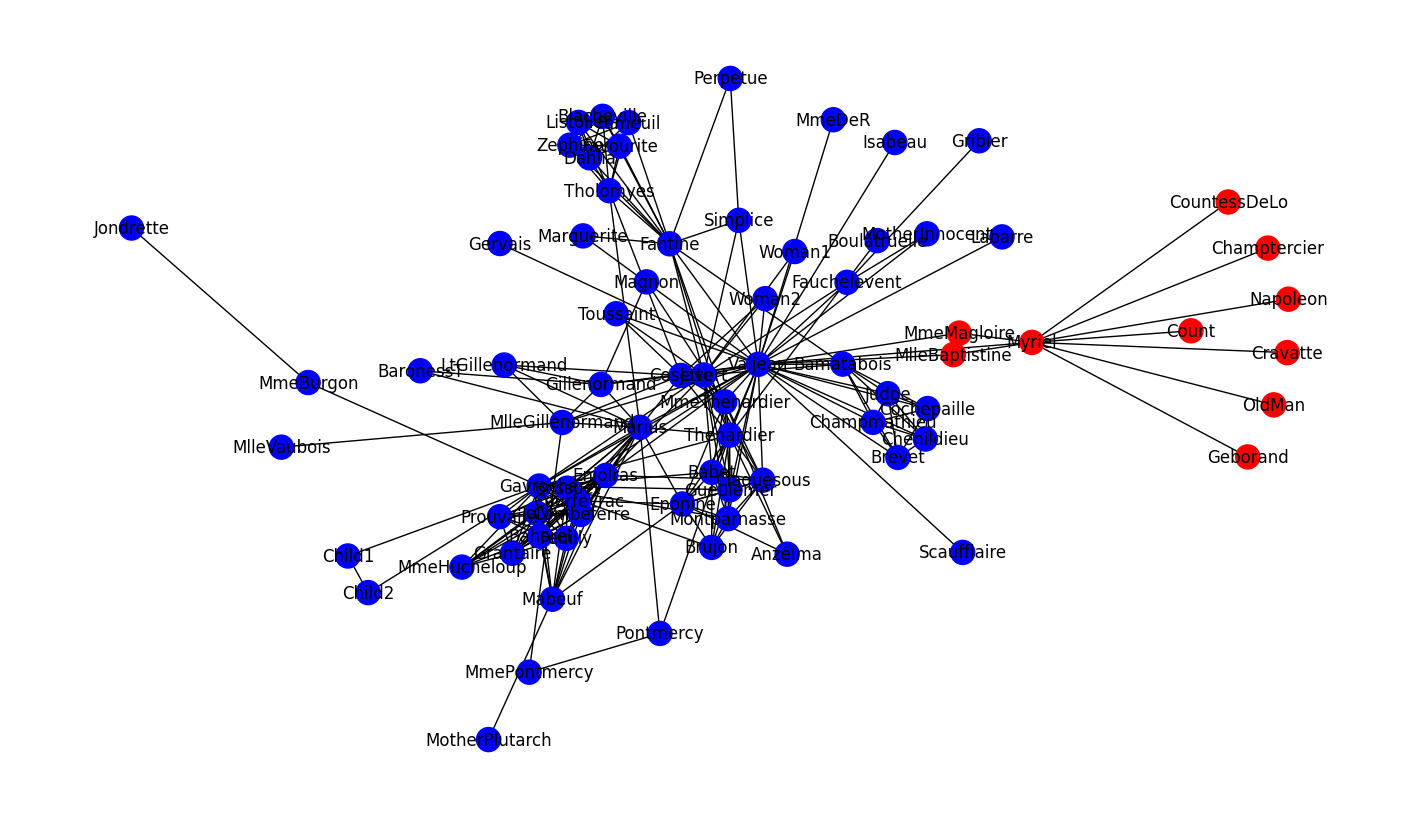

In [2]:
G = nx.les_miserables_graph()
group1, group2 = list(next(girvan_newman(G)))

plt.figure(figsize=(14, 8))
nx.draw(G, with_labels=True, node_color= ["red" if i in group1 else "blue" for i in G])
plt.show()

### Задание 2. Реализовать случайные блуждания алгоритма `DeepWalk` и построить множества схожих вершин.

In [3]:
def deep_walk(G, num_walks, walk_length):
    walks = []
    for node in G.nodes():
        for _ in range(num_walks):
            walk = [node]
            current_node = node
            for _ in range(walk_length - 1):
                neighbors = list(G.neighbors(current_node))
                if not neighbors:
                    break
                next_node = np.random.choice(neighbors)
                walk.append(next_node)
                current_node = next_node
            walks.append(walk)
    return walks

In [4]:
walks = deep_walk(G, num_walks = 1, walk_length = 5)
walks

[['Napoleon', 'Myriel', 'CountessDeLo', 'Myriel', 'Champtercier'],
 ['Myriel', 'MmeMagloire', 'Myriel', 'Geborand', 'Myriel'],
 ['MlleBaptistine', 'Myriel', 'MlleBaptistine', 'Valjean', 'Fauchelevent'],
 ['MmeMagloire', 'Valjean', 'Javert', 'Cosette', 'Thenardier'],
 ['CountessDeLo', 'Myriel', 'OldMan', 'Myriel', 'MmeMagloire'],
 ['Geborand', 'Myriel', 'MlleBaptistine', 'Myriel', 'OldMan'],
 ['Champtercier', 'Myriel', 'Valjean', 'Babet', 'MmeThenardier'],
 ['Cravatte', 'Myriel', 'Napoleon', 'Myriel', 'CountessDeLo'],
 ['Count', 'Myriel', 'MmeMagloire', 'MlleBaptistine', 'Valjean'],
 ['OldMan', 'Myriel', 'Valjean', 'Bossuet', 'Gavroche'],
 ['Valjean', 'Brevet', 'Judge', 'Bamatabois', 'Javert'],
 ['Labarre', 'Valjean', 'Simplice', 'Fantine', 'Valjean'],
 ['Marguerite', 'Valjean', 'Isabeau', 'Valjean', 'Brevet'],
 ['MmeDeR', 'Valjean', 'Fantine', 'Tholomyes', 'Fantine'],
 ['Isabeau', 'Valjean', 'Bamatabois', 'Javert', 'Montparnasse'],
 ['Gervais', 'Valjean', 'Isabeau', 'Valjean', 'MotherI

## Задание 3. Обучить эмбеддинги вершин, используя `SGD` и `negative sampling`.

Сэмплируем негативные пример как пример из противоположной группы, а положительные из своей, и преобразуем в тензоры с индексами.

In [5]:
def negative_sampling(G, group1, group2, num_neg_samples):
    neg_edge_list = []
    pos_set = set(G.edges())
    while len(neg_edge_list) < num_neg_samples:
        u, v = np.random.choice(G.nodes(), 2)
        if u == v or (u, v) in pos_set or (v, u) in pos_set:
            continue
        if (u in group1 and v in group2) or (u in group2 and v in group1):
            neg_edge_list.append((u, v))
    return neg_edge_list

def prepare_edge_tensors(G, group1, group2):
    pos_edge_list = [
        (u, v) for u, v in G.edges() if (u in group1 and v in group1) or (u in group2 and v in group2)
    ]
    neg_edge_list = negative_sampling(G, group1, group2, len(pos_edge_list))
    node_to_index = {node: i for i, node in enumerate(G.nodes())}

    numerical_pos_edge_list = [
        (node_to_index[u], node_to_index[v]) for u, v in pos_edge_list
    ]
    pos_edge_index = torch.tensor(numerical_pos_edge_list, dtype=torch.long).t().contiguous()

    numerical_neg_edge_list = [
        (node_to_index[u], node_to_index[v]) for u, v in neg_edge_list
    ]
    neg_edge_index = torch.tensor(numerical_neg_edge_list, dtype=torch.long).t().contiguous()

    return pos_edge_index, neg_edge_index

In [6]:
pos_edge_index, neg_edge_index = prepare_edge_tensors(G, group1, group2)

In [7]:
embedding_layer = nn.Embedding(len(G.nodes()), embedding_dim = 16)

optimizer = SGD(embedding_layer.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

pos_label = torch.ones(pos_edge_index.shape[1])
neg_label = torch.zeros(neg_edge_index.shape[1])
train_label = torch.cat([pos_label, neg_label], dim=0)

train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

In [8]:
for epoch in range(5000):
    optimizer.zero_grad()
    emb_u = embedding_layer(train_edge[0])
    emb_v = embedding_layer(train_edge[1])
    product = torch.sum(torch.mul(emb_u, emb_v), axis=1)
    pred = sigmoid(product)
    loss = loss_fn(pred, train_label)
    loss.backward()
    optimizer.step()

## Задание 4. Визуализировать эмбеддинги.

### Возьмем TSNE для размерности 2

In [9]:
def vis_emb(embedding_layer, G, group1, group2):
    X = embedding_layer.weight.data.numpy()
    tsne = TSNE(n_components=2)
    components = tsne.fit_transform(X)

    plt.figure(figsize=(8, 8))
    group1_x, group1_y = [], []
    group2_x, group2_y = [], []

    for i, node in enumerate(G.nodes()):
        if node in group1:
            group1_x.append(components[i, 0])
            group1_y.append(components[i, 1])
        else:
            group2_x.append(components[i, 0])
            group2_y.append(components[i, 1])

    plt.scatter(group1_x, group1_y, color="red")
    plt.scatter(group2_x, group2_y, color="blue")
    plt.legend()
    plt.show()

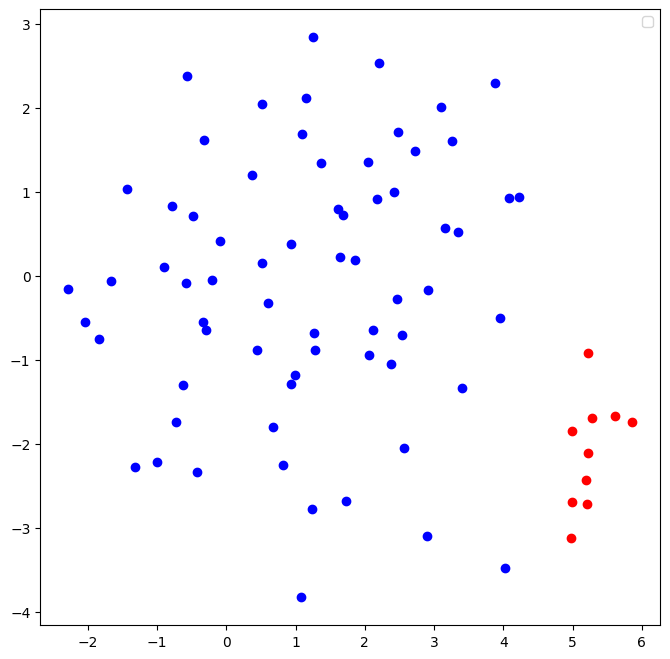

In [10]:
with torch.no_grad():
    vis_emb(embedding_layer, G, group1, group2)

## Задание 5. Также реализовать `node2vec` блуждания и обучить классификатор, используя его. Сравнить результаты.

### Добавим в блуждание параметры p (возврат к пред узлу) и q (новый узел)

In [11]:
def node2vec_walk(G, num_walks, walk_length, p, q):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                cur = walk[-1]
                neighbors = list(G.neighbors(cur))
                if neighbors:
                    if len(walk) == 1:
                        next_node = random.choice(neighbors)
                    else:
                        prev = walk[-2]
                        probabilities = []
                        for neighbor in neighbors:
                            if neighbor == prev:
                                probabilities.append(1 / p)
                            elif G.has_edge(prev, neighbor):
                                probabilities.append(1)
                            else:
                                probabilities.append(1 / q)
                        total = sum(probabilities)
                        probabilities = [prob / total for prob in probabilities]
                        next_node = random.choices(neighbors, probabilities)[0]
                    walk.append(next_node)
                else:
                    break
            walks.append(walk)
    return walks

In [12]:
def vis_emb_w2v(model, G, group1, group2):
    node_embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
    tsne = TSNE(n_components=2)
    components = tsne.fit_transform(node_embeddings)
    plt.figure(figsize=(8, 8))
    group1_x, group1_y = [], []
    group2_x, group2_y = [], []
    for i, node in enumerate(G.nodes()):
        if node in group1:
            group1_x.append(components[i, 0])
            group1_y.append(components[i, 1])
        else:
            group2_x.append(components[i, 0])
            group2_y.append(components[i, 1])
    plt.scatter(group1_x, group1_y, color="red")
    plt.scatter(group2_x, group2_y, color="blue")
    plt.legend()
    plt.show()

In [13]:
walks = node2vec_walk(G, num_walks = 6, walk_length = 15, p = 1., q = 0.5)
model = Word2Vec(
    sentences=[[str(node) for node in walk] for walk in walks],
    vector_size=16,
    window=5,
    min_count=0,
    sg=1,
    workers=4,
)

In [14]:
node_embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
labels = np.array([1 if node in group1 else 0 for node in G.nodes()])

X_train, X_test, y_train, y_test = train_test_split(node_embeddings, labels, test_size=0.3, random_state=42)
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

LogisticRegression()

In [15]:
accuracy = accuracy_score(y_test, clf.predict(X_test))
accuracy

1.0

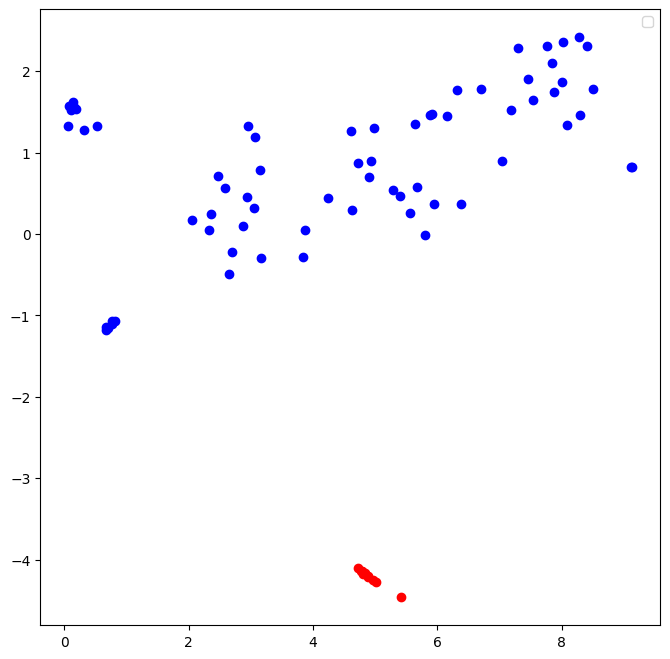

In [16]:
vis_emb_w2v(model, G, group1, group2)

**Вывод:** По визуализации эмбеддингов по tsne видно, что node2vec делает эмбеддинги значительно лучше (красная группа полностью отделена от синей), и просто SGD с семплированием работает хуже (красная группа локализована, но хуже отделима от синей). Поэтому node2vec лучше улавливает топологию графа.